Kinematics of  VFTS 682

In [2]:
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import sys
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/')
sys.path.insert(0, '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/')
import math
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter, MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatch
from plot_defaults import *
from matplotlib.collections import PatchCollection
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import aplpy


In [3]:
# Load data Gaia DR2 for VFTS682
# GAIA ID: 4657685637907503744, retrieved using the Vizier interface

mu_ra = 1.8429766110812542  # marcsec/yr 
err_mu_ra = 0.06974150031513375  # marcsec/yr

mu_dec =  0.7855134899438113  # marcsec/yr
err_mu_dec = 0.07997805252521194  # marcsec/yr

# # Radial velocities from Bestenlehner et al. 2011 (http://adsabs.harvard.edu/abs/2011A%26A...530L..14B)
# # from HeII4686
# rv = 315     # km/s
# err_rv = 15  # km/s
# # from NV lines
rv = 300 # km/s
err_rv = 10 #km/s

rv_30Dor = 270  # km/s
err_rv_30Dor = 10  # km/s


# # peculiar RV
drv = rv_30Dor - rv  
err_drv = err_rv+err_rv_30Dor

# # Distance, assumed
D = 50e3  # pc

# parallax -- not used
parallax = -0.02213454741230581  # note that it is negative!
e_parallax = 0.043642011613831244

# position on the sky (degrees)
RAvfts682   = 84.73136339876477
e_RAvfts682 = 0.036321212008208974
DEvfts682   = -69.07411071794998
e_DEvfts682 = 0.04825647078875183

In [4]:
## some functions, most constants come from $MESA_DIR/const/public/const_def.f90
def convertDpc_to_km(D):
    return D*3.086e13

def convertyr_to_sec(T):
    return T*3.1558149984e7

def convertmarcsec_to_rad(alpha):
    return alpha*math.pi/(648000000.0)

def convertmarcsec_to_deg(alpha):
    return alpha*2.778e-7

def prop_motion_to_km_s(mu, D):
    # D needs to be in parsec
    # mu in milliarcsec/yr
    return convertDpc_to_km(D)*(mu/convertyr_to_sec(1))*convertmarcsec_to_rad(1)

def remove_systems(array, ind_to_remove):
    ind_to_keep = np.array(1-ind_to_remove,dtype=bool)
    return array[ind_to_keep]

def min_array(array1, array2):
    if len(array1) != len(array2):
        print "arrays have different lengths!giving up..."
        return np.nan
    else:
        array = np.zeros(len(array1))
        for i in xrange(len(array1)):
            array[i] = min(array1[i], array2[i])
        return array

## read data files downloaded from vizier
# get filename and header
def getFileData(fname):
    ff = open(fname,'r')
    for i,line in enumerate(ff):
        if 'DR2Name|' in line:
            # print i
            col = line.split('|')
            break
    ff.close()
    src = np.genfromtxt(fname, comments='#', delimiter='|', skip_header=i+1)
    print col
    return src, col

# read file
def getData(fname):
    print "----------------"
    print fname
    print "----------------"

    src, col = getFileData(fname)
    
    # proper motion RA
    pmRA = src[:, col.index('pmRA')]
    # i_pmRA = pmRA >= 1 # # # this removes 4 clear outliers
    
    e_pmRA = src[:, col.index('e_pmRA')]
    
    # proper motion DEC
    pmDE = src[:, col.index('pmDE')]
    # i_pmDE = (pmDE>0.3931)*(pmDE<1) # # # This is used to remove 3 clear outliers
    # print min(pmDE[i_pmDE]), max(pmDE[i_pmDE])
            
    
    e_pmDE = src[:, col.index('e_pmDE')]

    # parallax
    par = src[:, col.index('Plx')]    
    e_par = src[:, col.index('e_Plx')]
   
    # positions
    RA = src[:, col.index('RA_ICRS')]
    e_RA = src[:, col.index('e_RA_ICRS')]/3.6e6  # note that positions are in degree, but errorbars are in milliarcsec, convert all to degrees
    DE = src[:, col.index('DE_ICRS')]
    e_DE = src[:, col.index('e_DE_ICRS')]/3.6e6 
    
    # remove clear outliers
    # pmDE = pmDE[i_pmDE]
    # pmRA = pmRA[i_pmDE]
    # e_pmDE = e_pmDE[i_pmDE]
    # e_pmRA = e_pmRA[i_pmDE]
    # par = par[i_pmDE]
    # e_par = e_par[i_pmDE]
    # print "selection routine is removing", len(RA)-np.sum(i_pmDE), "stars"
    
    return pmRA, e_pmRA, pmDE, e_pmDE, RA, e_RA, DE, e_DE, par, e_par


def getAvg(x,y, e_x, e_y):
    # returns the 1/error weighted average
    num_x = np.sum(x/(e_x)**2)
    den_x = np.sum(1/(e_x)**2)
    avg_x = num_x/den_x

    # now evaluate the error: standard error propagation with the
    Nx = len(x)
    err_avg_x = np.sqrt(Nx)/np.sum(1/(e_x)**2)

    # repeat for y component
    num_y = np.sum(y/(e_y)**2)
    den_y = np.sum(1/(e_y)**2)
    avg_y =  num_y/den_y

    Ny = len(y)
    err_avg_y = np.sqrt(Ny)/np.sum(1/(e_y)**2)

    return avg_x, err_avg_x, avg_y, err_avg_y



In [5]:
# Gaia Data
mu_ra = 1.8429766110812542  # marcsec/yr 
err_mu_ra = 0.06974150031513375  # marcsec/yr

mu_dec =  0.7855134899438113  # marcsec/yr
err_mu_dec = 0.07997805252521194  # marcsec/yr

## Mean projected motion components from Lennon et al. 2018
pmRA_around = 1.74
e_pmRA_around = 0.01
pmDEC_around = 0.70
e_pmDEC_around = 0.02


## relative motion Gaia
pmRA_gaia = mu_ra - pmRA_around
e_pmRA_gaia = err_mu_ra+e_pmRA_around
pmDEC_gaia = mu_dec - pmDEC_around
e_pmDEC_gaia = err_mu_dec+e_pmDEC_around

pm = np.sqrt(pmRA_gaia**2+pmDEC_gaia**2)
e_pm = (1./pm)*np.sqrt((pmRA_gaia**2)*(e_pmRA_gaia**2)+(pmDEC_gaia**2)*(e_pmDEC_gaia)**2)




print "======================="
print "Gaia relative motion"
print "RA:", pmRA_gaia, "+/-", e_pmRA_gaia
print "DEC:", pmDEC_gaia, "+/-", e_pmDEC_gaia
print "projected 2D:", pm, "+/-", e_pm

print "-----------------------"
print "RA:", prop_motion_to_km_s(pmRA_gaia,D), "+/-", prop_motion_to_km_s(e_pmRA_gaia,D)
print "DEC:", prop_motion_to_km_s(pmDEC_gaia,D), "+/-", prop_motion_to_km_s(e_pmDEC_gaia,D)
print "======================="

Gaia relative motion
RA: 0.102976611081 +/- 0.0797415003151
DEC: 0.0855134899438 +/- 0.0999780525252
projected 2D: 0.13385342502958308 +/- 0.08856114703240674
-----------------------
RA: 24.4100040953 +/- 18.9022568214
DEC: 20.2704732445 +/- 23.6992133063


In [6]:
# load HST catalog
fname = '/scratch/mathieu/HST_pm_imants.dat'
srcHST = np.genfromtxt(fname, skip_header=1)
ff = open(fname,'r')
for i, line in enumerate(ff):
    if i==0:
        col = line.split()
        print col
    # if i==2:
    #     print line    
    #     print len(line.split()), len(col)
        break
ff.close()
ivfts682 = np.argmin(np.absolute(srcHST[:, col.index("VFTS")]-682))
print "VFTS682 has ID", srcHST[ivfts682,col.index("VFTS")], "in the VFTS catalog"
pmRA_HST = -1.0*srcHST[ivfts682,col.index("pxm")] # note the -1 because of the misalignment between Gaia and HST frames
e_pmRA_HST = srcHST[ivfts682,col.index("exm")]
pmDEC_HST = srcHST[ivfts682, col.index("pym")]
e_pmDEC_HST = srcHST[ivfts682,col.index("eym")]
## check flag for HST observations
flag = srcHST[ivfts682, col.index("F")]
if flag == 6:
    #means
    print "================================================================"
    print "HST data:"
    print "based on GO-12499 & 13359 observations with WFC3/UVIS only;"
    print "based on archival WFPC2 and GO-12499 observations with both"
    print "cameras, ACS/WFC and WFC3/UVIS. This catalog is described in"
    print "detail (AJ,2015,150:89, Paper I)"
    print "================================================================"
print "pmRA:", pmRA_HST, "+/-", e_pmRA_HST, "marcsec/yr"
print "pmDEC:", pmDEC_HST, "+/-", e_pmDEC_HST, "marcsec/yr"
print "----------------------"

pm_HST = np.sqrt(pmRA_HST**2+pmDEC_HST**2)
e_pm_HST = (1./pm)*np.sqrt((pmRA_HST**2)*(e_pmRA_HST**2)+(pmDEC_HST**2)*(e_pmDEC_HST)**2)
print pm_HST, "+/-", e_pm_HST


['ID', 'F775', 'pxm', 'pym', 'exm', 'eym', 'F', 'pxa', 'pya', 'n', 'pxu', 'pyu', 'n', 'pxc', 'pyc', 'n', 'exa', 'eya', 'cxa', 'cya', 'qxa', 'qya', 'exu', 'eyu', 'cxu', 'cyu', 'qxu', 'qyu', 'exc', 'eyc', 'cxc', 'cyc', 'qxc', 'qyc', 'V', 'e_V', 'I', 'e_I', 'V-I', 'x', 'y', 'RA', 'Dec', 'VFTS']
VFTS682 has ID 682.0 in the VFTS catalog
HST data:
based on GO-12499 & 13359 observations with WFC3/UVIS only;
based on archival WFPC2 and GO-12499 observations with both
cameras, ACS/WFC and WFC3/UVIS. This catalog is described in
detail (AJ,2015,150:89, Paper I)
pmRA: 0.01 +/- 0.13 marcsec/yr
pmDEC: 0.2 +/- 0.1 marcsec/yr
----------------------
0.2002498439450079 +/- 0.14973248135438716


In [7]:
# 3D relative velocity cf. surroundings
def get3Dv(vx,dvx,vy,dvy,vz,dvz):
    v = np.sqrt(vx**2+vy**2+vz**2)
    dv = (1/v)*np.sqrt((vx*dvx)**2+(vy*dvy)**2+(vz*dvz)**2)
    return v, dv

print "GAIA:-------------------"
vra = prop_motion_to_km_s(pmRA_gaia, D)
dvra = prop_motion_to_km_s(e_pmRA_gaia, D)
print vra, dvra

vdec = prop_motion_to_km_s(pmDEC_gaia, D)
dvdec = prop_motion_to_km_s(e_pmDEC_gaia, D)
print vdec, dvdec

vr = drv
err = err_drv
v, dv = get3Dv(vra,dvra,vdec,dvdec,vr,err)
print "-----------------"
print "3D velocity:", v, "+/-", dv
print "2D velocity:", np.sqrt(vra**2+vdec**2) , "+/-", (1/np.sqrt(vra**2+vdec**2))*np.sqrt((vra*dvra)**2+(vdec*dvdec)**2)
print "-----------------"

print "=============================="

print "HST:-------------------" 
vra = prop_motion_to_km_s(pmRA_HST, D)
dvra = prop_motion_to_km_s(e_pmRA_HST, D)
print vra, dvra

vdec = prop_motion_to_km_s(pmDEC_HST, D)
dvdec = prop_motion_to_km_s(e_pmDEC_HST, D)
print vdec, dvdec

vr = drv
err = err_drv
v, dv = get3Dv(vra,dvra,vdec,dvdec,vr,err)
print "-----------------"
print "3D velocity:", v, "+/-", dv
print "2D velocity:", np.sqrt(vra**2+vdec**2) , "+/-", (1/np.sqrt(vra**2+vdec**2))*np.sqrt((vra*dvra)**2+(vdec*dvdec)**2)
print "-----------------"


GAIA:-------------------
24.4100040953 18.9022568214
20.2704732445 23.6992133063
-----------------
3D velocity: 43.6662385085534 +/- 20.53022741981076
2D velocity: 31.72917246771292 +/- 20.99290255373504
-----------------
HST:-------------------
2.3704415827014085 30.81574057511831
47.40883165402818 23.70441582701409
-----------------
3D velocity: 56.15350667676048 +/- 22.724006169542292
2D velocity: 47.46805570167145 +/- 23.72480113500931
-----------------


INFO: Auto-setting vmin to -2.286e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.479e+01 [aplpy.core]


Traceback (most recent call last):
  File "/scratch/mathieu/anaconda2/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 32] Broken pipe
Logged from file core.py, line 676
Traceback (most recent call last):
  File "/scratch/mathieu/anaconda2/lib/python2.7/logging/__init__.py", line 874, in emit
    stream.write(fs % msg)
IOError: [Errno 32] Broken pipe
Logged from file core.py, line 681


DX 735.9750000000004
DY 735.375


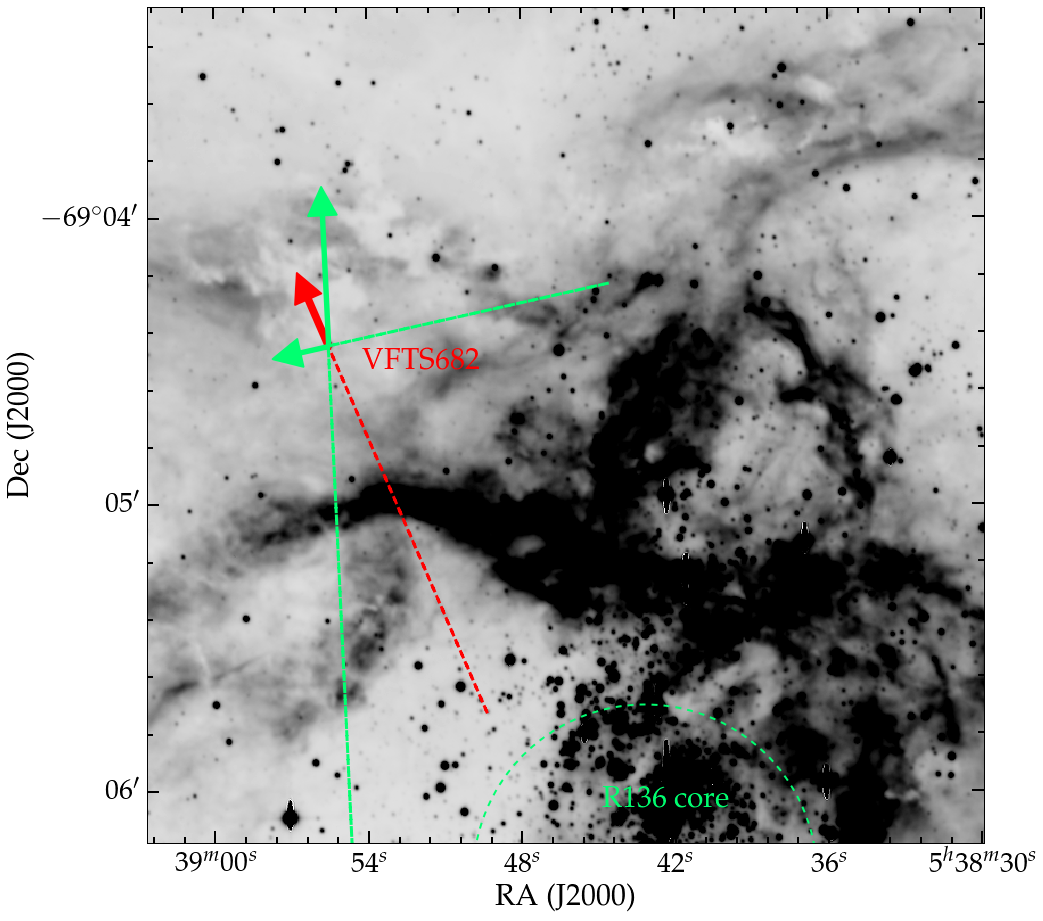

In [9]:
root = '/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/figures/ESO_field/'
fitsFileV  = root+'ADP_WFI_30DOR1_V89_V1.0.fits'

#### orange: 'c'

ffig = aplpy.FITSFigure(fitsFileV, figsize=(15,15))#, downsample=300) ###remove downsample=300 for final plot
ffig.show_grayscale(aspect='equal') #possible arg: aspect='auto'

ffig.set_theme('publication')
ffig.ticks.set_linewidth(2)
ffig.ticks.set_length(12)


# #cut image on relevant part
# x axis
xmin, xmax = ffig._ax1.get_xlim()
ffig._ax1.set_xlim(3*xmax/4.0+237.2+50, xmax-1037.2-50)
xmin1, xmax1 = ffig._ax1.get_xlim()
print "DX", xmax1-xmin1

# y axis
ymin, ymax = ffig._ax1.get_ylim()
ffig._ax1.set_ylim(ymax/2.0+300+25, ymax/2+ymax/4-975-62)
ymin1, ymax1 = ffig._ax1.get_ylim()
print "DY", ymax1-ymin1

# ffig._ax1.set_xlim(4500.5, 7000.5) #cut image on y-direction
ffig.tick_labels.set_xformat('hh:mm:ss')
ffig.tick_labels.set_yformat('dd:mm')

#labels
ffig.add_label(0.62, 0.05, 'R136 core', relative=True, color='#01FF70', size=30)
# ffig.show_markers(RA_around, DE_around, edgecolor='b', lw=2)
ffig.show_markers(RAvfts682, DEvfts682, edgecolor='r', layer='vfts682', lw=2)
ffig.add_label(RAvfts682-0.015, DEvfts682-0.001, 'VFTS682', relative=False, color="r", size=30)
ffig.show_circles(84.68, -69.105, 0.01, color='#01FF70', linewidth=2, linestyle='--')

# to scale arrows
len_factor = 0.05
kin_age = 0.9*10**6
#len_factor = kin_age

# best value Gaia only
ffig.show_arrows(RAvfts682, DEvfts682, len_factor*pmRA_gaia, len_factor*pmDEC_gaia, color='r', width=5, lw=2,head_length=25, head_width=25)

# prolungation in the past (Gaia only)
ffig.show_arrows(RAvfts682, DEvfts682, convertmarcsec_to_deg(-kin_age*pmRA_gaia), convertmarcsec_to_deg(-kin_age*pmDEC_gaia), color='r', width=0, lw=3, head_length=0, head_width=0, linestyle='--')

# # error-cone (Gaia only)
ffig.show_arrows(RAvfts682, DEvfts682, len_factor*(pmRA_gaia-e_pmRA_gaia), len_factor*(pmDEC_gaia+e_pmDEC_gaia), color='#01FF70',head_length=25, head_width=25, width=3,  lw=2)
ffig.show_arrows(RAvfts682, DEvfts682, len_factor*(pmRA_gaia+e_pmRA_gaia), len_factor*(pmDEC_gaia-e_pmDEC_gaia), color='#01FF70',head_length=25, head_width=25, width=3,  lw=2)
# show prolungations in opposite direction
ffig.show_arrows(RAvfts682, DEvfts682, convertmarcsec_to_deg(-kin_age*(pmRA_gaia-e_pmRA_gaia)), convertmarcsec_to_deg(-kin_age*(pmDEC_gaia+e_pmDEC_gaia)), color='#01FF70', head_length=0, head_width=0, width=0, lw=3, linestyle='--')
ffig.show_arrows(RAvfts682, DEvfts682, convertmarcsec_to_deg(-kin_age*(pmRA_gaia+e_pmRA_gaia)), convertmarcsec_to_deg(-kin_age*(pmDEC_gaia-e_pmDEC_gaia)), color='#01FF70', head_length=0, head_width=0, width=0, lw=3, linestyle='--')


# # best value HST only
# ffig.show_arrows(RAvfts682, DEvfts682, len_factor*pmRA_HST, len_factor*pmDEC_HST, color='#01FF70', width=5, lw=2,head_length=25, head_width=25)

# # prolungation in the past (HST only)
# ffig.show_arrows(RAvfts682, DEvfts682, convertmarcsec_to_deg(-kin_age*pmRA_HST), convertmarcsec_to_deg(-kin_age*pmDEC_HST), color='c', width=0, lw=3, head_length=0, head_width=0, linestyle='--')

# # # error-cone (HST only)
# ffig.show_arrows(RAvfts682, DEvfts682, len_factor*(pmRA_HST-e_pmRA_HST), len_factor*(pmDEC_HST+e_pmDEC_HST), color='#CC99FF',head_length=25, head_width=25, width=3,  lw=2)
# ffig.show_arrows(RAvfts682, DEvfts682, len_factor*(pmRA_HST+e_pmRA_HST), len_factor*(pmDEC_HST-e_pmDEC_HST), color='#CC99FF',head_length=25, head_width=25, width=3,  lw=2)
# # show prolungations in opposite direction
# ffig.show_arrows(RAvfts682, DEvfts682, convertmarcsec_to_deg(-kin_age*(pmRA_HST-e_pmRA_HST)), convertmarcsec_to_deg(-kin_age*(pmDEC_HST+e_pmDEC_HST)), color='#CC99FF', head_length=0, head_width=0, width=0, lw=3, linestyle='--')
# ffig.show_arrows(RAvfts682, DEvfts682, convertmarcsec_to_deg(-kin_age*(pmRA_HST+e_pmRA_HST)), convertmarcsec_to_deg(-kin_age*(pmDEC_HST-e_pmDEC_HST)), color='#CC99FF', head_length=0, head_width=0, width=0, lw=3, linestyle='--')

ffig.savefig(root+'/../main_plot_good_gaia_only.pdf', dpi=300)
# ffig.savefig(root+'/../main_plot_good.png')

===================================================
===================================================
===================================================
===================================================

In [8]:
## average of both measures
print "-----------------"
print "Averaged HST and Gaia data "
print "-----------------"

# These are weighted averages according to Eq.1 where the number of observations is N=2 (HST+Gaia) 

pmRA_avg = (pmRA_HST/(e_pmRA_HST**2)+pmRA_gaia/(e_pmRA_gaia**2))/(1.0/(e_pmRA_HST**2)+1.0/(e_pmRA_gaia**2))
e_pmRA_avg = np.sqrt(2)/((1.0/(e_pmRA_HST**2)+1.0/(e_pmRA_gaia**2)))

pmDEC_avg = (pmDEC_HST/(e_pmDEC_HST**2)+pmDEC_gaia/(e_pmDEC_gaia**2))/(1/(e_pmDEC_HST**2)+1/(e_pmDEC_gaia**2))
e_pmDEC_avg = np.sqrt(2)/((1.0/(e_pmDEC_HST**2)+1.0/(e_pmDEC_gaia**2)))


print "pmRA:", pmRA_avg, "+/-", e_pmRA_avg
print "pmDEC:", pmDEC_avg, "+/-", e_pmDEC_avg


-----------------
Averaged HST and Gaia data 
-----------------
pmRA: 0.09444898280825563 +/- 0.005374575097774452
pmDEC: 0.13121574689784496 +/- 0.005543385084977828


----------------
/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/asu.tsv
----------------
['DR2Name', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'e_Plx', 'pmRA', 'e_pmRA', 'pmDE', 'e_pmDE', 'epsi', 'Gmag', 'e_Gmag', 'RV', 'e_RV\n']
# stars surroundings: 66


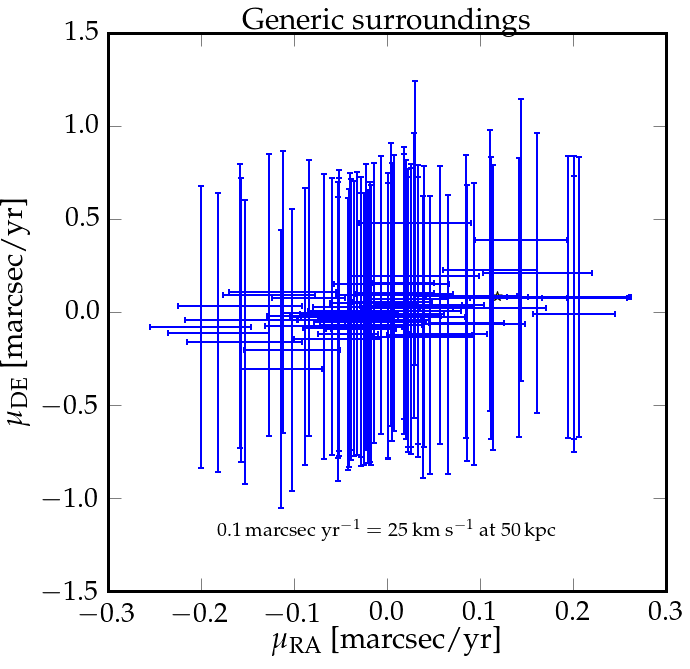

In [6]:
# plot the surrounding regions in proper motion space
fig = plt.figure(figsize=(10., 10.))
gs = gridspec.GridSpec(100,100) 
ax = plt.subplot(gs[:,:])
## fname_around='/scratch/mathieu/MMPS/SCRIPTS_dirty/my_script/binaries/binary_c/30Dor/vfts682/data/asu.tsv'
pmRA_around, e_pmRA_around, pmDE_around, e_pmDE_around, RA_around, e_RA_around, DE_around, e_DE_around, par_around, e_par_around = getData(fname_around) 
avg_pmRA_around, err_avg_pmRA_around, avg_pmDE_around, err_avg_pmDE_around= getAvg(pmRA_around,pmDE_around, e_pmRA_around, e_pmDE_around) # weighted with 1/error^2

print "# stars surroundings:", len(pmRA_around)

# plot relative to region
ax.errorbar(pmRA_around-avg_pmRA_around, pmDE_around-avg_pmDE_around, xerr=e_pmRA_around+err_avg_pmRA_around, yerr=e_pmDE_around+avg_pmDE_around, ms=10, lw=0, ecolor='b', elinewidth=2)
# plot measurements
# ax.errorbar(pmRA_around, pmDE_around, xerr=e_pmRA_around, yerr=e_pmDE_around, ms=10, lw=0, ecolor='b', elinewidth=2)
# ax.errorbar(avg_pmRA_around, avg_pmDE_around, xerr=err_avg_pmRA_around, yerr=err_avg_pmDE_around, color='r', markersize=1000)
ax.set_xlabel("$\mu_\mathrm{RA}$ [marcsec/yr]", fontsize=30)
ax.set_ylabel("$\mu_\mathrm{DE}$ [marcsec/yr]", fontsize=30)
ax.set_title("Generic surroundings", fontsize=30)
ax.text(0.5,0.1,"$0.1\,\mathrm{marcsec\ yr^{-1}}=25\,\mathrm{km\ s^{-1}}$ at 50\,kpc", fontsize=20, transform=ax.transAxes, ha="center")

ax.scatter(mu_ra-avg_pmRA_around, mu_dec-avg_pmDE_around, marker='*', c='y', s=100)

